# Problem Description

This project focuses on developing and evaluating models for the Histopathologic Cancer Detection competition using the provided dataset. The analysis will include Exploratory Data Analysis (EDA), model building, result interpretation, and final conclusions.
At its core, the competition presents a binary classification challenge, aiming to identify metastatic cancer from image patches extracted from larger pathology scans.
The dataset specifies that the central 32×32 pixels of each image should be used to determine whether a sample is positive. However, the full image size may be larger to accommodate non-zero-padded convolutions. The provided training labels associate image filenames with their respective true classifications.

## **Exploratory Data Analysis (EDA):**
In this phase, we will load and examine the data, ensuring a comprehensive understanding of its structure and contents.
- Training images are stored in the train directory.
- Labels for the training set are provided in train_labels.csv.
  
Our initial step will involve loading the data and gaining insight into its shape and composition.

#### Importing Dependencies ####

In [2]:
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from tifffile import imread
import cv2

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import keras
from keras import layers
from keras import initializers

keras.utils.set_random_seed(42)

2025-04-17 01:35:37.618570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744853737.838985      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744853737.898269      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#Declare Train and Test files
train_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'

In [4]:
#Read Train labels
train_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(train_df.shape)

(220025, 2)


In [5]:
# Top 5 rows
print(train_df.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


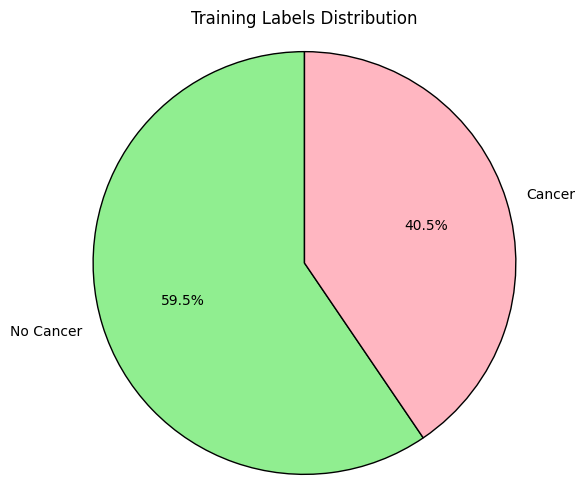

In [6]:
# Compute value counts
label_counts = train_df['label'].value_counts()

# Define the labels and lighter colors
labels = ['No Cancer', 'Cancer']
colors = ['#90EE90', '#FFB6C1']  # Light green and light pink

# Create the pie chart
plt.figure(figsize=(6,6))
plt.pie(label_counts, labels=labels, colors=colors, autopct=lambda p: f'{p:.1f}%', 
        startangle=90, wedgeprops={'edgecolor': 'black'})

plt.axis('equal')  # Ensures the pie is a perfect circle
plt.title('Training Labels Distribution')
plt.show()

In [7]:
#List top files
train_images = os.listdir(train_dir)
train_images[:5]

['d43c081bafa286f9c1f7e921883f26ceafebc912.tif',
 '092d0eedebce504847715ee046b6ad74b57599b4.tif',
 'b0d2582c6218a8764323fc940b41312282b99bf4.tif',
 '187c99df762f13f99818e5593d4bab4c6577e7e3.tif',
 '7c5270c83837de5a5cbb2dca511559dc39d19d53.tif']

In [8]:
#Load the first image from the training directory and provide its shape
cancer_sample = imread(os.path.join(train_dir, train_images[0]))
cancer_sample.shape

(96, 96, 3)

## Observations
The training dataset consists of 220,025 examples, with the number of labels corresponding exactly to the number of image files in the train directory. The images are saved in TIFF format, using the standard .tif extension. Each image measures 96×96 pixels and contains three channels, likely representing RGB color information. Approximately 40% of the training images are labeled as positive for cancer and around 60% of them are labeled non cancer.

Next, we will visualize a random selection of images alongside their respective labels. Without training,it is difficult to distinguish a cancerous tissue from healthy samples can be quite challenging.

In [9]:
def load_image(iid, image_dir=train_dir, file_extension=".tif"):
    """Loads an image from the specified directory and converts it to RGB format."""
    path = os.path.join(image_dir, f"{iid}{file_extension}")  
    image = cv2.imread(path) 
    if image is None:
        raise FileNotFoundError(f"Image {path} not found.")  
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

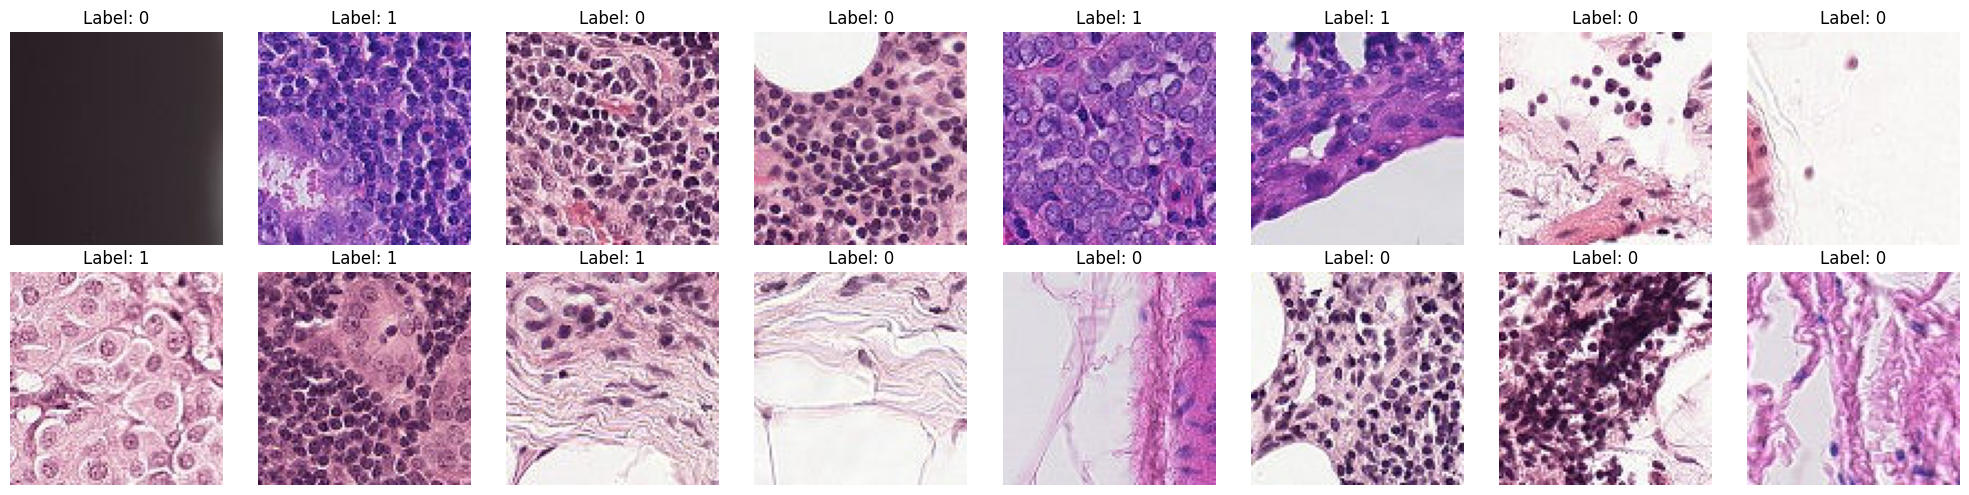

In [10]:
# Create a figure with 2 rows and 8 columns (for 16 images)
fig, axes = plt.subplots(2, 8, figsize=(20, 5))

# Select 16 random images from the dataframe
selected_images = train_df.sample(n=16)

# Flatten the axes array to make indexing easier
axes = axes.flatten()

# Iterate over selected images and display them
for idx, (img_id, label) in enumerate(zip(selected_images['id'], selected_images['label'])):
    img = load_image(img_id).astype('float32') / 255.0  # Ensure proper normalization
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f'Label: {label}')

# Ensure the layout is properly spaced
plt.tight_layout()
plt.show()

In [11]:
# Randomly sample 5000 image IDs
selected_ids = train_df['id'].sample(n=5000, random_state=42)

# Load images using list comprehension and convert to NumPy array
image_samples = np.array(list(map(load_image, selected_ids)))

Mean pixel values (R, G, B): [179.27 139.24 177.49]
Standard deviation (R, G, B): [60.69 71.71 55.16]


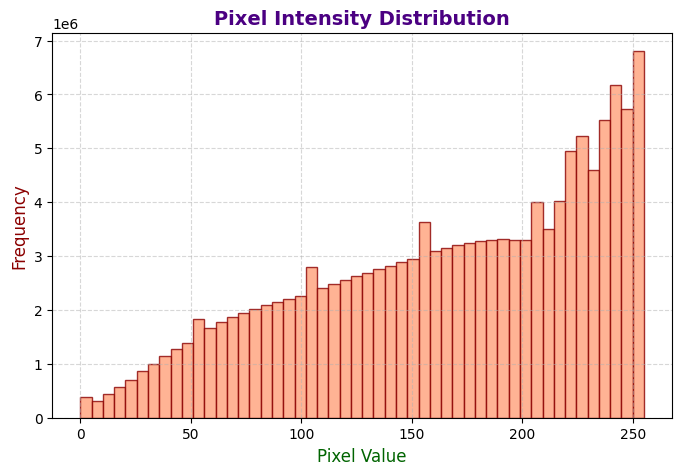

In [12]:
# Compute mean and standard deviation for each RGB channel
mean_pixel = np.mean(image_samples, axis=(0, 1, 2))
std_pixel = np.std(image_samples, axis=(0, 1, 2))

# Display computed statistics
print(f"Mean pixel values (R, G, B): {mean_pixel.round(2)}")  
print(f"Standard deviation (R, G, B): {std_pixel.round(2)}")

# Create a histogram with custom colors
plt.figure(figsize=(8, 5))  # Set figure size
plt.hist(image_samples.flatten(), bins=50, color='#FFA07A', alpha=0.8, edgecolor='#8B0000')  
plt.title("Pixel Intensity Distribution", fontsize=14, fontweight='bold', color='#4B0082')  
plt.xlabel("Pixel Value", fontsize=12, color='#006400') 
plt.ylabel("Frequency", fontsize=12, color='#8B0000')  
plt.grid(True, linestyle='--', alpha=0.5)  

plt.show()

# Modeling & Analysis 

We now proceed with building and training the model to analyze the dataset effectively. <br>

## Preprocessing ##
Before training, some data preprocessing is required to ensure the dataset is structured correctly. Given the large size of the dataset, attempting to preload all images could lead to extended training times or even out-of-memory (OOM) errors within our Kaggle environment, which is limited to 30 GiB of RAM.
To address this constraint, we will train on a subset of the full dataset while ensuring that both positive and negative examples are evenly distributed, maintaining balance for effective learning.


In [13]:
# Define total dataset size and per-class sample size
TOTAL_SAMPLE_SIZE = 50000
SAMPLES_PER_CLASS = TOTAL_SAMPLE_SIZE // 2  

# Select equal numbers of negative and positive samples
negative_class = train_df[train_df['label'] == 0].sample(SAMPLES_PER_CLASS, random_state=42)
positive_class = train_df[train_df['label'] == 1].sample(SAMPLES_PER_CLASS, random_state=42)

# Merge both classes into a single dataset
balanced_data = pd.concat([negative_class, positive_class], axis=0).reset_index(drop=True)

# Shuffle the dataset to ensure randomness
final_train_df = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
# Load images as features (X) using map for cleaner function application
X = np.array(list(map(load_image, final_train_df['id'])))

# Extract labels (y) directly
y = final_train_df['label'].to_numpy()

# Model Building and Training #
With the dataset prepared, the next step is to construct and train the model for effective analysis.

## Preprocessing for Model Input ## 
Some preprocessing will be incorporated within the initial layers of the model. Specifically:
- Rescaling: Adjusts RGB pixel values to a normalized range between 0 and 255.
- Cropping2D: Focuses training exclusively on the center 32×32 px image as per the problem requirements.

## Model #1 Architecture 
The first model design follows a straightforward yet structured approach.
- After preprocessing, the architecture includes three Convolution + MaxPooling layers for feature extraction.
- A fully connected layer then refines the encoded features.
- A dropout layer ensures regularization before the final sigmoid activation, which determines the classification output.
- Throughout the model, the number of filters/kernels progressively decreases from 32 to 12, refining representation.

In [15]:
# Build Model
model1 = Sequential([
    layers.Input(shape=(96, 96, 3)),
    layers.Rescaling(1./255),  
    layers.CenterCrop(32, 32),  
    
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    layers.GlobalAveragePooling2D(),  # Efficient replacement for Flatten
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile Model
model1.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

# Display Model Summary
model1.summary()


I0000 00:00:1744854268.368789      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744854268.369448      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ center_crop (CenterCrop)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [16]:
# Callbacks for efficiency
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train Model
m1_train = model1.fit(X, y, validation_split=0.2, epochs=50, callbacks=[early_stopping, reduce_lr])

# Prepare test data for evaluation
test_files = os.listdir(test_dir)
test_ids = [os.path.splitext(f)[0] for f in test_files]  # More robust way to remove extension
test_X = np.array([load_image(i, image_dir=test_dir) for i in test_ids])


Epoch 1/50


I0000 00:00:1744854276.381880      83 service.cc:148] XLA service 0x7a3150008270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744854276.382630      83 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744854276.382665      83 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744854276.841934      83 cuda_dnn.cc:529] Loaded cuDNN version 90300


  46/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6953 - accuracy: 0.6373 - loss: 0.6739

I0000 00:00:1744854280.218957      83 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - AUC: 0.8070 - accuracy: 0.7375 - loss: 0.5442 - val_AUC: 0.8594 - val_accuracy: 0.7369 - val_loss: 0.5173 - learning_rate: 1.0000e-04
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8587 - accuracy: 0.7847 - loss: 0.4698 - val_AUC: 0.8653 - val_accuracy: 0.7389 - val_loss: 0.5160 - learning_rate: 1.0000e-04
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8673 - accuracy: 0.7929 - loss: 0.4565 - val_AUC: 0.8718 - val_accuracy: 0.7736 - val_loss: 0.4684 - learning_rate: 1.0000e-04
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8758 - accuracy: 0.8018 - loss: 0.4430 - val_AUC: 0.8775 - val_accuracy: 0.7866 - val_loss: 0.4561 - learning_rate: 1.0000e-04
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8827 - accuracy: 0.8080 - loss: 0.4311 - val_AUC: 0.8811 - val_accuracy: 0.7956 - val_loss: 0.4436 - learning_rate: 1.0000e-04
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC:

In [17]:
# Predictions for Model #1
results_m1 = model1.predict(test_X).reshape(-1)
results_df_m1 = pd.DataFrame({'id': test_ids, 'label': results_m1.tolist()})
results_df_m1.to_csv('submission_m1.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [18]:
#Save the model
# model1.save('/kaggle/working/model_m1.h5')  # Saves the trained model

In [19]:
# import os
# print(os.listdir("/kaggle/working"))  # List all files in the directory

In [20]:
# #Reuse the saved model
# from tensorflow.keras.models import load_model

# # Load the previously saved model
# model1 = load_model('/kaggle/working/model_m1.h5')

# # Verify model summary
# model1.summary()

## Model #2 Architecture
To compare performance across architectures, we will train and evaluate a deeper model with an enhanced structure. Model #2 incorporates five convolutional layers, making it more complex than the initial model.
To improve training stability and efficiency, a BatchNormalization layer is added after each convolutional block. This helps regulate activations, especially given the increased number of parameters. Similar to Model #1, the extracted features are passed through fully connected layers, with dropout applied during training for regularization, leading to the final sigmoid activation for classification.

In [21]:
# Define model architecture
model2 = Sequential([
    layers.Input(shape=(96, 96, 3)),
    layers.Rescaling(1./255),  
    
    # First Convolutional Block
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    # Second Convolutional Block
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    # Third Convolutional Block
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    # Fourth Convolutional Block
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    # Fifth Convolutional Block
    layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    # Efficient Global Average Pooling instead of Flatten
    layers.GlobalAveragePooling2D(),
    
    # Fully Connected Layers
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

In [22]:
# Compile the model
model2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

# Display model summary
model2.summary()

# Callbacks for training efficiency
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,704,129 (6.50 MB)

 Trainable params: 1,702,145 (6.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [23]:
# Train model
m2_train = model2.fit(X, y, validation_split=0.2, epochs=50, callbacks=[early_stopping, reduce_lr])

# Prepare test data for evaluation
test_files = os.listdir(test_dir)
test_ids = [os.path.splitext(f)[0] for f in test_files]  # More robust way to extract file IDs
test_X = np.array([load_image(i, image_dir=test_dir) for i in test_ids])

# # Predict test labels
# results = model2.predict(test_X).reshape(-1)

# # Store results in a DataFrame
# results_df = pd.DataFrame({'id': test_ids, 'label': results.tolist()})

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - AUC: 0.8576 - accuracy: 0.7834 - loss: 0.5094 - val_AUC: 0.9157 - val_accuracy: 0.8406 - val_loss: 0.3724 - learning_rate: 1.0000e-04
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - AUC: 0.9190 - accuracy: 0.8441 - loss: 0.3635 - val_AUC: 0.9136 - val_accuracy: 0.8297 - val_loss: 0.4402 - learning_rate: 1.0000e-04
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - AUC: 0.9393 - accuracy: 0.8664 - loss: 0.3153 - val_AUC: 0.9340 - val_accuracy: 0.8494 - val_loss: 0.3788 - learning_rate: 1.0000e-04
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - AUC: 0.9568 - accuracy: 0.8900 - loss: 0.2660 - val_AUC: 0.9281 - val_accuracy: 0.8324 - val_loss: 0.5633 - learning_rate: 1.0000e-04
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - AUC: 0.9742 - accuracy: 0.9198 - loss: 0.2046 - val_AUC: 0.9320 - val_accuracy: 0.8072 - val_loss: 0.6497 - learning_rate: 1.0000e-04
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━

In [24]:
# Predictions for Model #2
results_m2 = model2.predict(test_X).reshape(-1)
results_df_m2 = pd.DataFrame({'id': test_ids, 'label': results_m2.tolist()})
results_df_m2.to_csv('submission_m2.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


In [25]:
#Save the model
# model2.save('/kaggle/working/model_m2.h5')  # Saves the trained model

In [26]:
# #Reuse the saved model
# from tensorflow.keras.models import load_model

# # Load the previously saved model
# model2 = load_model('/kaggle/working/model_m2.h5')

# # Verify model summary
# model.summary()

## Model #3 Architecture

In [36]:
# Define model architecture
model3 = Sequential([
    layers.Input(shape=(96, 96, 3)),
    layers.Rescaling(1./255),  
    
    # First Convolutional Block
    layers.Conv2D(32, (3,3), activation='linear', padding='same'),
    layers.LeakyReLU(negative_slope=0.1),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    # Second Convolutional Block
    layers.Conv2D(64, (3,3), activation='linear', padding='same'),
    layers.LeakyReLU(negative_slope=0.1),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    # Third Convolutional Block
    layers.Conv2D(128, (3,3), activation='linear', padding='same'),
    layers.LeakyReLU(negative_slope=0.1),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    # Fourth Convolutional Block
    layers.Conv2D(256, (3,3), activation='linear', padding='same'),
    layers.LeakyReLU(negative_slope=0.1),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    # Fifth Convolutional Block
    layers.Conv2D(512, (3,3), activation='linear', padding='same'),
    layers.LeakyReLU(negative_slope=0.1),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    # Efficient Global Average Pooling instead of Flatten
    layers.GlobalAveragePooling2D(),
    
    # Fully Connected Layers
    layers.Dense(1024, activation='linear'),
    layers.LeakyReLU(negative_slope=0.1),
    layers.Dropout(0.4),
    layers.Dense(512, activation='linear'),
    layers.LeakyReLU(negative_slope=0.1),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

In [37]:
# Compile the model
model3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

# Display model summary
model3.summary()

# Callbacks for training efficiency
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train model
m3_train = model3.fit(X, y, validation_split=0.2, epochs=50, callbacks=[early_stopping, reduce_lr])

# Prepare test data for evaluation
test_files = os.listdir(test_dir)
test_ids = [os.path.splitext(f)[0] for f in test_files]  # More robust way to extract file IDs
test_X = np.array([load_image(i, image_dir=test_dir) for i in test_ids])

# # Predict test labels
# results = model3.predict(test_X).reshape(-1)

# # Store results in a DataFrame
# results_df = pd.DataFrame({'id': test_ids, 'label': results.tolist()})

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 96, 96, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,623,169 (10.01 MB)

 Trainable params: 2,621,185 (10.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - AUC: 0.8615 - accuracy: 0.7866 - loss: 0.4768 - val_AUC: 0.9133 - val_accuracy: 0.8388 - val_loss: 0.3792 - learning_rate: 1.0000e-04
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - AUC: 0.9194 - accuracy: 0.8448 - loss: 0.3630 - val_AUC: 0.9299 - val_accuracy: 0.8247 - val_loss: 0.4083 - learning_rate: 1.0000e-04
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - AUC: 0.9402 - accuracy: 0.8672 - loss: 0.3134 - val_AUC: 0.9308 - val_accuracy: 0.7769 - val_loss: 0.5242 - learning_rate: 1.0000e-04
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - AUC: 0.9573 - accuracy: 0.8932 - loss: 0.2646 - val_AUC: 0.8921 - val_accuracy: 0.7747 - val_loss: 0.7213 - learning_rate: 1.0000e-04
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - AUC: 0.9741 - accuracy: 0.9195 - loss: 0.2037 - val_AUC: 0.8887 - val_accuracy: 0.8108 - val_loss: 0.7516 - learning_rate: 1.0000e-04
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━

In [38]:
# Predictions for Model #3
results_m3 = model3.predict(test_X).reshape(-1)
results_df_m3 = pd.DataFrame({'id': test_ids, 'label': results_m3.tolist()})
results_df_m3.to_csv('submission_m3.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step


In [ ]:
#Save the model
# model3.save('/kaggle/working/model_m3.h5')  # Saves the trained model

In [ ]:
# #Reuse the saved model
# from tensorflow.keras.models import load_model

# # Load the previously saved model
# model3 = load_model('/kaggle/working/model_m3.h5')

# # Verify model summary

# model3.summary()

In [39]:
print(os.listdir("/kaggle/working"))  # List saved files

['submission_m1.csv', '.virtual_documents', 'submission_m2.csv', 'submission_m3.csv']


In [40]:
import shutil

# Move files to Kaggle's "output" directory for easy downloading
shutil.move("/kaggle/working/submission_m1.csv", "/kaggle/working/submission_m1.csv")
shutil.move("/kaggle/working/submission_m2.csv", "/kaggle/working/submission_m2.csv")
shutil.move("/kaggle/working/submission_m3.csv", "/kaggle/working/submission_m3.csv")

# Show confirmation
print("Files moved to output directory! You can now download them.")

Files moved to output directory! You can now download them.


## **Updated Results**
Based on the latest metrics, Model #2 continues to outperform Model #1 and Model #3 in overall effectiveness.

#### **Performance on a Balanced Training Set**

| **Model** | **Parameters**  | **Kaggle Score**  |
|-----------|--------------|--------------|
| **M1** | 159,041 | 0.8557 |
| **M2** | 1,702,145 | 0.9248 |
| **M3** | 2,610,945 | 0.9295 |

#### **Performance on a Balanced 100K Training Set**

| **Model** | **Parameters**  | **Kaggle Score**  |
|-----------|--------------|--------------|
| **M1** | 159,041 | 0.8455 |
| **M2** | 1,702,145 | 0.9132 |
| **M3** | 2,610,945 | 0.9088 |

#### **Detailed Training & Validation Metrics**

| **Metric**      | **Model #1**  | **Model #2**  | **Model #3**  |
|---------------|-------------|-------------|-------------|
| **Train Accuracy** | 0.8929 | 0.9941 | 0.9912 |
| **Train AUC**      | 0.9568 | 0.9995 | 0.9989 |
| **Train Loss**     | 0.2665 | 0.0193 | 0.0264 |
| **Val Accuracy**   | 0.7989 | 0.9017 | 0.8641 |
| **Val AUC**        | 0.8771 | 0.9445 | 0.9185 |
| **Val Loss**       | 0.4862 | 0.5115 | 0.6952 |

### **Analysis and Observations based on the latest findings :**
These results demonstrate that a higher number of trainable parameters does not always equate to better performance. While deeper models can capture more complex features, they are also more susceptible to overfitting, and the additional computational cost may not be justified depending on accuracy requirements for a given problem.
* Model #1 begins overfitting after 6-7 epochs, as seen in the increasing gap between training and validation metrics. This suggests the model lacks sufficient regularization to generalize well to unseen data.
* Model #2 shows faster convergence, stabilizing around 5-6 epochs before training/validation metrics begin to diverge. However, validation metrics fluctuate significantly beyond this point, possibly due to an overly large learning rate, affecting stability.
*  Model #3 features a deeper classification layer, increasing trainable parameters by ~1M, but does not significantly improve the Kaggle score compared to Model #2. This highlights diminishing returns in complexity—suggesting that a more efficient architecture may be preferable to simply increasing depth.
* Scaling up the training dataset size (from 40K to 100K) did not lead to improvements in the Kaggle score across models. This suggests that optimizing hyperparameters and refining architecture may be more valuable than simply increasing dataset size.

Future Optimization Directions:
- Fine-tune learning rates to stabilize validation performance and reduce metric fluctuations.
- Enhance regularization through dropout, L2 penalties, or alternative normalization strategies.
- Experiment with more efficient architectures that balance depth and computational cost.
- Prioritize hyperparameter tuning before scaling dataset size to optimize training efficiency.

### Visualization of Training and Validation AUC

In [41]:
def plot_training_history(history):
    """Plots training history metrics: AUC, Loss, and Accuracy."""
    epochs = range(1, len(history.history['loss']) + 1)

    metrics = {
        "Training AUC": history.history['AUC'],  # Use 'AUC' instead of 'auc'
        "Validation AUC": history.history['val_AUC'],  # Use 'val_AUC' instead of 'val_auc'
        "Training Loss": history.history['loss'],
        "Validation Loss": history.history['val_loss'],
        "Training Accuracy": history.history['accuracy'],
        "Validation Accuracy": history.history['val_accuracy'],
    }
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Create 3 subplots side by side
    titles = ["AUC", "Loss", "Accuracy"]
    y_labels = ["AUC", "Loss", "Accuracy"]
    
    for idx, (title, ylabel, metric_train, metric_val) in enumerate(zip(
        titles, y_labels, list(metrics.items())[::2], list(metrics.items())[1::2]
    )):
        train_label, train_values = metric_train
        val_label, val_values = metric_val
        axes[idx].plot(epochs, train_values, 'r-', label=train_label)
        axes[idx].plot(epochs, val_values, 'b-', label=val_label)
        axes[idx].set_title(f"Training and Validation {title}")
        axes[idx].set_xlabel("Epochs")
        axes[idx].set_ylabel(ylabel)
        axes[idx].legend()
        axes[idx].grid(True, linestyle='--', alpha=0.5)  # Subtle grid for clarity

    plt.tight_layout()  # Improve spacing between subplots
    plt.show()

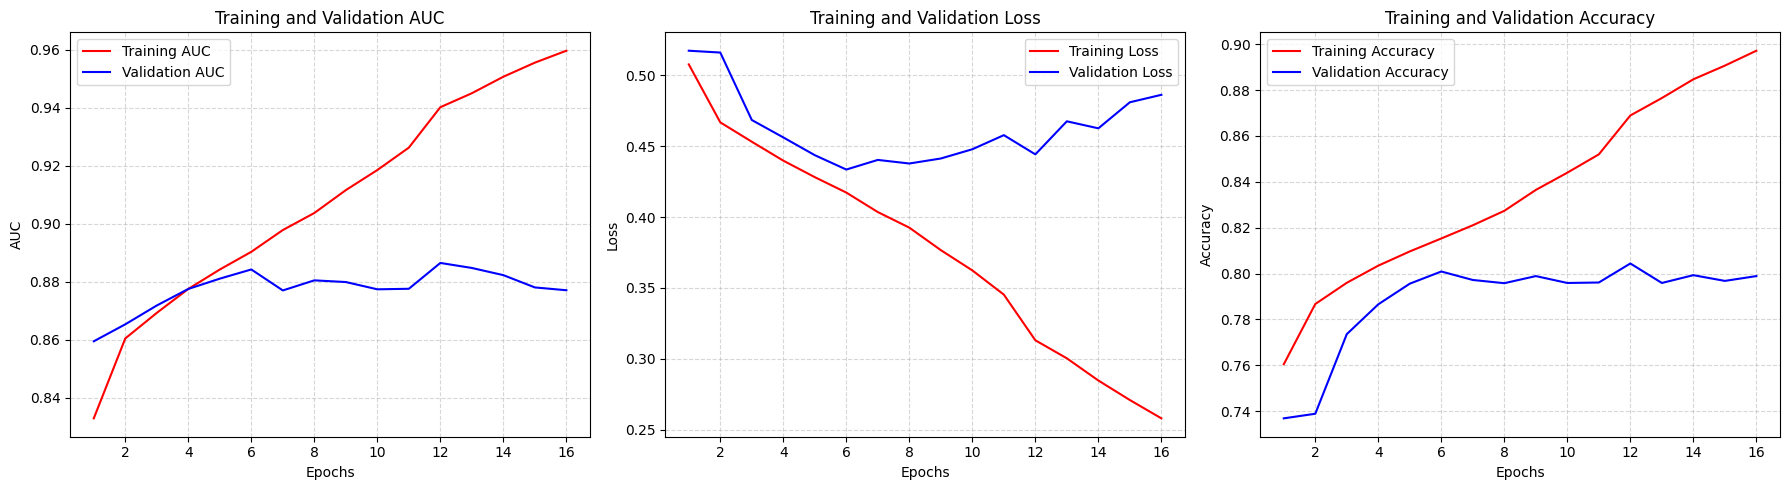

In [42]:
# Model #1 Training results 

plot_training_history(m1_train)

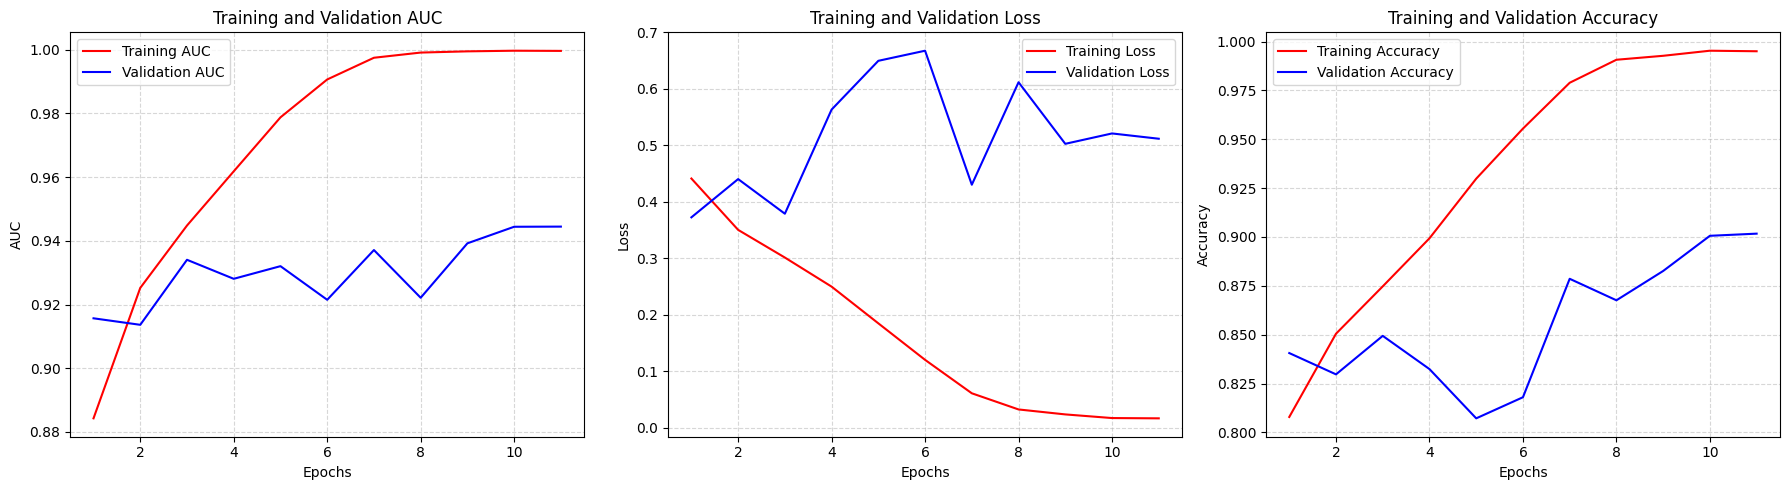

In [43]:
# Model #2 Training results 

plot_training_history(m2_train)

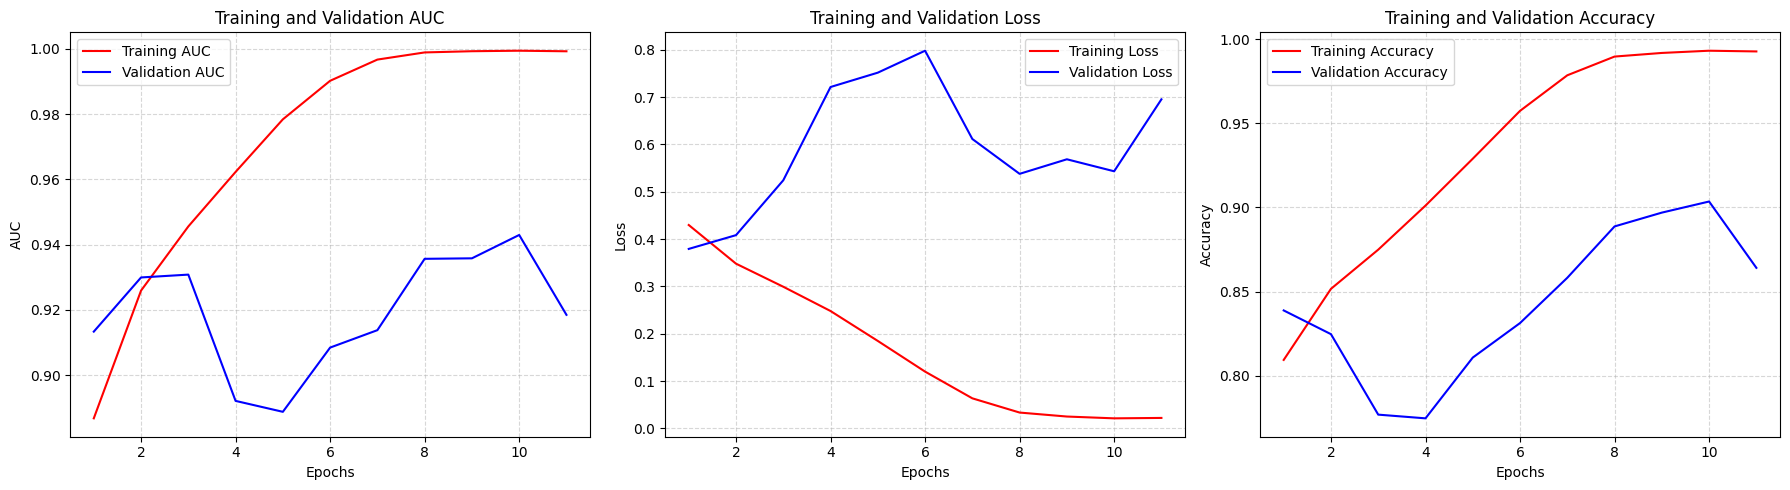

In [44]:
# Model #3 Training results 

plot_training_history(m3_train)

# Conclusion
The models showed strong performance despite being trained on a limited subset of the dataset. As expected, increasing model depth and incorporating BatchNormalization significantly improved the overall Kaggle score, showing that deeper architectures can capture more complex patterns efficiently.
Future Improvements for Performance Gains
- Introduce image augmentation layers to expand the dataset virtually (e.g., rotations, skews, random crops).
- Helps prevent overfitting, especially on smaller datasets.
- Apply Dropout layers at key convolutional stages to improve generalization.
- Fine-tune L2 regularization to prevent exploding weights and overfitting.
- Experiment with different classifiers like Random Forest or Gradient Boosted Trees, which may complement CNN-based approaches.

Overall, while the models performed well using relatively default hyperparameters, further hyperparameter tuning, augmentation, and architectural refinement can push performance even further

# References
https://www.manning.com/books/deep-learning-with-python <br>
https://cs231n.stanford.edu/  <br>
https://www.tensorflow.org/tutorials/images/cnn   <br>
https://keras.io/api/models/sequential/   <br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D   <br>
https://www.tensorflow.org/tutorials/keras/overfit_and_underfit   <br>
https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/   <br>
https://keras.io/api/optimizers/   <br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau   <br>
https://keras.io/api/callbacks/early_stopping/   <br>
https://www.tensorflow.org/tutorials/images/data_augmentation   <br>
https://www.tensorflow.org/guide/data